# Toy Model: 

$$\nabla\,\mathsf{T} = \mathrm{C}\,\mathsf{T} + \mathsf{F}$$ 

where,

$\mathsf{T} = 
\begin{bmatrix}
    \mathsf{T_O} \\
    \mathsf{T_A} 
\end{bmatrix}$ is the vector containing sub-component temperatures,

$\mathsf{F} = 
\begin{bmatrix}
    \emptyset \\
    \mathsf{F}(t) 
\end{bmatrix}$ is the forcing function, usually assumed to be stochastic white noise for the atmospheric component. The diagonal operator $\nabla$ encodes the time-dependent factorisation of the constituent ODEs such that,

$$\nabla = 
\begin{bmatrix}
    \mathsf{m}\displaystyle\frac{\mathsf{d}}{\mathsf{d}t} & \emptyset \\
    \emptyset & \displaystyle\frac{\mathsf{d}}{\mathsf{d}t} 
\end{bmatrix},$$ 

where $\mathsf{m}$ encodes the relative temporal scale, and lastly

$$\mathrm{C} = 
\begin{bmatrix}
    \mathrm{C}_\mathsf{OO} & \mathrm{C}_\mathsf{OA} \\
    \mathrm{C}_\mathsf{AO} & \mathrm{C}_\mathsf{AA} 
\end{bmatrix}$$

is the covariance matrix. The system of equations may be written in coupled form as

$$\displaystyle\mathsf{m}\frac{\mathsf{dT_O}}{\mathsf{d}t} = \mathrm{C}_\mathsf{OO}\mathsf{T_O} + \mathrm{C}_\mathsf{OA}\mathsf{T_A},$$

$$\displaystyle\frac{\mathsf{dT_A}}{\mathsf{d}t} = \mathrm{C}_\mathsf{AO}\mathsf{T_O} + \mathrm{C}_\mathsf{AA}\mathsf{T_A} + \mathsf{F}(t).$$

In the absence of stochastic forcing. i.e. $\mathsf{F}(t) = \emptyset$, the system of coupled ODEs are easily solved using <font color='blue'>scipy.integrate.odeint()</font> to yield the time-series and the auto- and cross-correlations.


In [1]:
# environment
import matplotlib.font_manager as fm
import numpy as np
import random as rand
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
import os 
import math as mt
%matplotlib inline

cwd = os.getcwd()
pwd = os.path.abspath(os.path.join(cwd, os.pardir))
fontloc = pwd + '/Fonts/SFMono-Regular.otf'
font = fm.FontProperties(fname = fontloc,size = 8); prop = font
proplr = fm.FontProperties(fname = fontloc,size = 12)

fontlocit = pwd + '/Fonts/SFMono-RegularItalic.otf'
fontit = fm.FontProperties(fname = fontlocit,size = 8)

#ticks font
def ticks(ax, size):
    font = fm.FontProperties(fname = fontloc,size = size)
    for label in ax.get_xticklabels():
        label.set_fontproperties(font)
    for label in ax.get_yticklabels():
        label.set_fontproperties(font)

In [2]:
#sample initial conditions
Toi = 1.0
Tai = 5.0

# model parameters, variables and functions
tune = 0.10           #model tuning parameter
Coo = -1.08 * tune
Coa = 1.0 * tune
Cao = 0.1 * tune
Caa = -1.12 * tune
m = 10.0

# time series
t_start = 0.0
t_end = 5000.0
time_samples = 5000
resolution = (t_end - t_start)/time_samples

# DA samples
time_stable = 0.5     #ignore first <N> samples as DA stabilises; fraction of total DA steps

def autocorr(x,t):
    result = np.correlate(x, x, mode='same')
    lag_time = np.linspace(start = -t.max()/2, stop = t.max()/2, num = time_samples + 1)
    return [lag_time, result]

def crosscorr(x,y,t):
    result = np.correlate(x, y, mode='same')
    lag_time = np.linspace(start = -t.max()/2, stop = t.max()/2, num = time_samples + 1)
    return [lag_time, result]

def f(x,t):
    To = x[0]
    Ta = x[1]
    f0 = (1/m)*(Coo*To + Coa*Ta)
    f1 = Cao*To + Caa*Ta
    return [f0,f1]

t = np.linspace(start=t_start,stop=t_end,num=time_samples + 1)

In [3]:
# solve ODEs
x0 = [Toi,Tai]
soln = odeint(f,x0,t)
To = soln[:,0]
Ta = soln[:,1]

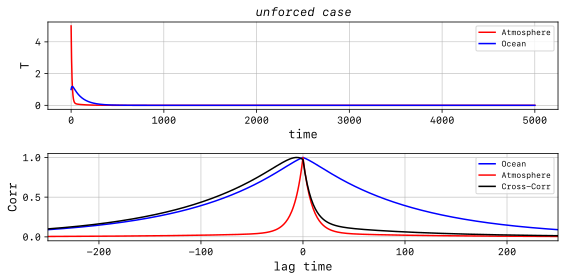

In [4]:
#plot results
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize=(8,4),dpi=120);
plt.subplot(2, 1, 1)
plt.xlabel('time',fontproperties=font,fontsize=12)
plt.ylabel('T',fontproperties=font,fontsize=12)
plt.plot(t,Ta,'r',t,To,'b')
ax = gca(); ticks(ax,10); ax.set_title('unforced case',fontproperties=fontit,fontsize=12);
plt.gca().legend(('Atmosphere','Ocean'),prop=prop);
plt.grid(linewidth=0.5); ax.set_axisbelow(True)

[lag_time_To, autocorr_To] = autocorr(To,t)
[lag_time_Ta, autocorr_Ta] = autocorr(Ta,t)
[lag_time_T, crosscorr_T] = crosscorr(Ta,To,t)

plt.subplot(2, 1, 2)
plt.plot(lag_time_To,autocorr_To/float(autocorr_To.max()),'b',lag_time_Ta,autocorr_Ta/float(autocorr_Ta.max()),'r',lag_time_T,crosscorr_T/float(abs(crosscorr_T).max()),'k')
plt.xlabel('lag time',fontproperties=font,fontsize=12)
plt.ylabel('Corr',fontproperties=font,fontsize=12)
ax = gca(); ticks(ax,10)
plt.gca().legend(('Ocean','Atmosphere','Cross-Corr'),prop=prop);
plt.tight_layout(); 
plt.grid(linewidth=0.5); ax.set_axisbelow(True)
ax.set_xlim([-250, 250]);

In the presence of the stochastic forcing term(s), one must find alternative ways to solve the coupled ODEs as <font color='red'>scipy.integrate.odeint()</font> wouldn't work in this case. We use <font color='blue'>sdeint()</font> in this case.

In [5]:
import sdeint

# define forcing function (weiner process with <cross-section>)
scale = 0.10          #relative amplitude of stochastic forcing
crosssec = scale * Tai

# set white noise forcing amplitude
W = np.diag([0.0,crosssec])

# redefine unforced part
C = np.array([[(1/m)*Coo, (1/m)*Coa],
              [Cao, Caa]])

def unforc(x, t):
    return C.dot(x)

def forc(x, t):
    return W

soln = sdeint.itoint(unforc,forc,x0,t)
To = soln[:,0]
Ta = soln[:,1]

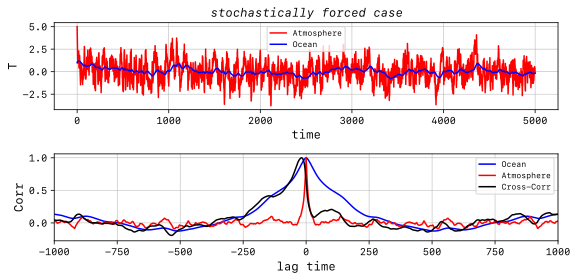

In [6]:
#plot results
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize=(8,4),dpi=120);
plt.subplot(2, 1, 1)
plt.xlabel('time',fontproperties=font,fontsize=12)
plt.ylabel('T',fontproperties=font,fontsize=12)
plt.plot(t,Ta,'r',t,To,'b')
ax = gca(); ticks(ax,10); ax.set_title('stochastically forced case',fontproperties=fontit,fontsize=12);
plt.gca().legend(('Atmosphere','Ocean'),prop=prop);
plt.grid(linewidth=0.5); ax.set_axisbelow(True)

[lag_time_To, autocorr_To] = autocorr(To,t)
[lag_time_Ta, autocorr_Ta] = autocorr(Ta,t)
[lag_time_T, crosscorr_T] = crosscorr(Ta,To,t)

plt.subplot(2, 1, 2)
plt.plot(lag_time_To,autocorr_To/float(autocorr_To.max()),'b',lag_time_Ta,autocorr_Ta/float(autocorr_Ta.max()),'r',lag_time_T,crosscorr_T/float(abs(crosscorr_T).max()),'k')
plt.xlabel('lag time',fontproperties=font,fontsize=12)
plt.ylabel('Corr',fontproperties=font,fontsize=12)
ax = gca(); ticks(ax,10)
plt.gca().legend(('Ocean','Atmosphere','Cross-Corr'),prop=prop);
plt.tight_layout();
plt.grid(linewidth=0.5); ax.set_axisbelow(True)
ax.set_xlim([-1000, 1000]);


We are able to reproduce the asymmetry in cross-correlation between oceanic and atmospheric states. This asymmetry is a function of the initial temperature anomalies and the forcing function $\mathsf{F}$. 



# Variance in peak cross-correlation

In order to quantify to variance in peak cross-correlation, we run an experiment where a distribution of initial conditions is considered. 

In [7]:
#solve the system of ODEs with a sample set of initial conditions
samples = 500
Toi_lim = Toi      #maximum amplitude of variability in ocean
Tai_lim = Tai      #maximum amplitude of variability in atmosphere
peak_corr = []
To_l = []; Ta_l = []

#calculate trajectories for all samples
VecCorr = []; LagCorr = []
for i in range(samples):
    x0 = [rand.uniform(0.0, Toi_lim), rand.uniform(0.0, Tai_lim)]
    soln = sdeint.itoint(unforc,forc,x0,t)
    To_t = soln[:,0]; To_l.append(To_t)    #list with all oceanic temperatures per sample
    Ta_t = soln[:,1]; Ta_l.append(Ta_t)    #list with all atmospheric temperatures per sample
    [lag_time, crosscor] = crosscorr(Ta_t,To_t,t)
    VecCorr.append(crosscor); LagCorr.append(lag_time)
    max_index = np.argmax(crosscor)
    peak_corr.append(abs(lag_time[max_index]))

    
CorrTraj = []; CorrTrajMax = []
for item in np.arange(0, samples):
    CorrTraj.append(VecCorr[item]/np.max(abs(VecCorr[item])))
    CorrTrajMax.append(max(VecCorr[item]/np.max(abs(VecCorr[item]))))

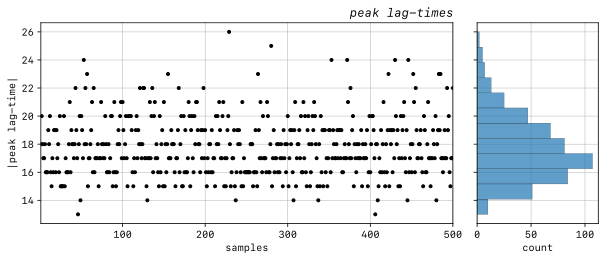

In [11]:
from matplotlib.gridspec import GridSpec
%config InlineBackend.figure_format = 'svg'
       
#plot cross-corr statistics vs lag-times
fig = plt.figure(figsize=(10,5), dpi=100);
gs = GridSpec(4,4)
ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])

ax_joint.plot(np.arange(1, samples + 1), np.abs(peak_corr), 'k',linewidth=0.0, marker='.')
ax_marg_y.hist(np.abs(peak_corr),orientation="horizontal",alpha=0.7, density=False, edgecolor='black', linewidth=0.25, bins = 12)
ticks(ax_joint,10); ticks(ax_marg_y,10); 
ax_joint.grid(linewidth=0.5); ax_joint.set_axisbelow(True);
ax_joint.autoscale(enable=True, axis='x', tight=True)

# Turn off tick labels on marginals
plt.setp(ax_marg_y.get_yticklabels(), visible=False)
plt.setp(ax_marg_y.get_xticklabels(), visible=True)
plt.grid(linewidth=0.5); ax_marg_y.set_axisbelow(True);

# Set labels on joint
ax_joint.set_xlabel('samples',fontproperties=font,fontsize=10)
ax_joint.set_ylabel('|peak lag-time|',fontproperties=font,fontsize=10);
ax_joint.set_title('peak lag-times',fontproperties=fontit,fontsize=12, loc='right');
label = ax_marg_y.set_xlabel('count',fontproperties=font,fontsize=10);

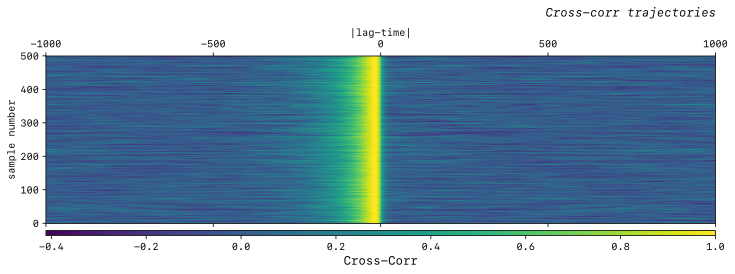

In [9]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pylab import *
from matplotlib.colors import LogNorm
%config InlineBackend.figure_format = 'svg'

CorrTrajRaw = CorrTraj; CorrTraj = []
for row in CorrTrajRaw:
    row_new = []
    for index in arange(t_start,t_end):
        row_new.append(row[int(index/resolution)])
            
    CorrTraj.append(row_new) 

#draw trajectories of Cross-Corr for 50 samples
fig, ax = plt.subplots(figsize=(12,12), dpi=200);
im = ax.matshow(np.array(CorrTraj),origin='lower');
ax.grid(which='minor')
ax.set_aspect(1.0)
ax.set_xlim([(t[-1] - t[0])/2 - 1000, (t[-1] - t[0])/2 + 1000]);

#colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="3%", pad = 0.1)
cb = plt.colorbar(im, cax=cax,label='Cross-Corr',orientation="horizontal");
axc = cb.ax
text = axc.xaxis.label
text.set_font_properties(proplr)
ticks(axc,10);

ax.set_ylabel('sample number',fontproperties=font,fontsize=10); 
ax.xaxis.set_label_position('top');
ax.set_xlabel('|lag-time|',fontproperties=font,fontsize=10); 
xlabels = ax.get_xticks().tolist()
xlabels_lag = [int(item - max(LagCorr[-1])) for item in xlabels]
ax.set_xticklabels(xlabels_lag)

ticks(ax,10);
ax.set_title('Cross-corr trajectories',fontproperties=fontit,fontsize=12, y=1.2, loc='right');
